In [1]:
# Useful resources
# https://medium.com/analytics-vidhya/testing-multiple-machine-learning-models-at-once-without-getting-a-headache-5aefb0e7df03
# Potentially look into ensemble models

In [2]:
# In prep
import pandas as pd
import utm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

seed = 38 # Seed for train/val split

In [3]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [4]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]

    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))

    # group by datetime, tag, tower and antenna, compute mean power, pivot to antennas
    sim_dat_filt = (
        sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
        .mean()
        .reset_index()
        .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values='Power')
        .reset_index()
        .rename(columns={1: 'ant1', 2: 'ant2', 3: 'ant3', 4: 'ant4'})
        .fillna(value=0) # Need to check the impact of this
    )
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)

    return sim_dat_filt

In [5]:
# Get simulation data
sim_data_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\RTdat_sim_only_20230202.xlsx'
sim_data = pd.read_excel(sim_data_path)
sim_data['DateAndTime'] = pd.to_datetime(sim_data['DateAndTime'])

# Get tower locations
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'
tower_locs = pd.read_excel(radio_tower_xy_path)


In [7]:
# Initial pass over the data using lazy predict to identify possible options
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# print(models)

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [ ]:
scoring = ['mean_squared_error', 'mean_absolute_error']

In [8]:
# Drilling into top performing models for paramater optimisation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create a list of test dictionaries
KNeighborsRegressor_params = [{"n_neighbors":3}, {"n_neighbors":5}, {"n_neighbors":7}]
AdaBoostRegressor_params = [{"n_estimators":25}, {"n_estimators":50}, {"n_estimators":75}]

# Create classes for the models
modelclasses = [
    ["K neighbours regressor", KNeighborsRegressor, KNeighborsRegressor_params],
    ["Ada boost regressor", AdaBoostRegressor, AdaBoostRegressor_params]
]

In [48]:
# Pre-processing parameters to test
# Variable parameters
data_type = ['Simulation'] # Simulation or Live BTF, or could do both
frequencies = ['1min', '5min']
cv = [] #To be updated

# Fixed parameters
predictors = ['ant1', 'ant2', 'ant3', 'ant4']
responses = ['xOffset', 'yOffset']

In [49]:
trained_models = []
for freq in frequencies:
    sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
    x = sim_data_preproc[predictors]
    y = sim_data_preproc['xOffset'] # Will need to adjust this to iterate over x and y xOffset

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

    for modelname, Model, params_list in modelclasses:
        for params in params_list:
            model = Model(**params)
            scores = cross_val_score(model, X_train, y_train, cv=3)
            score = np.mean(scores)
            trained_models.append((modelname, model, params, freq, score))

In [33]:
trained_models.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, freq, score in trained_models:
    print(modelname, params, freq, score)

K neighbours regressor {'n_neighbors': 7} 10min 0.18977129589222608
K neighbours regressor {'n_neighbors': 7} 3min 0.15069430520867144
K neighbours regressor {'n_neighbors': 3} 5min 0.14641551911210912
Ada boost regressor {'n_estimators': 75} 3min 0.14426671402217264
Ada boost regressor {'n_estimators': 75} 5min 0.13352588908293572
Ada boost regressor {'n_estimators': 50} 5min 0.13114078428353956
K neighbours regressor {'n_neighbors': 3} 3min 0.12485813941406114
Ada boost regressor {'n_estimators': 50} 3min 0.1127175156072973
K neighbours regressor {'n_neighbors': 3} 10min 0.11022100683669182
Ada boost regressor {'n_estimators': 25} 3min 0.09278710874213252
K neighbours regressor {'n_neighbors': 5} 3min 0.08707488405614976
K neighbours regressor {'n_neighbors': 7} 5min 0.07829964213343658
K neighbours regressor {'n_neighbors': 5} 1min 0.07383227623564086
K neighbours regressor {'n_neighbors': 5} 10min 0.05678162736144451
Ada boost regressor {'n_estimators': 25} 5min 0.05275225887165136

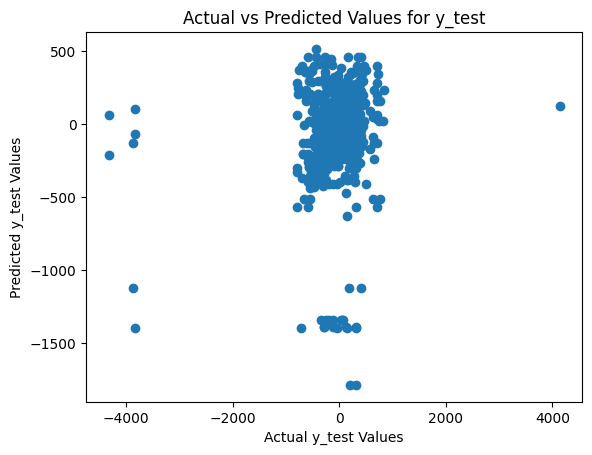

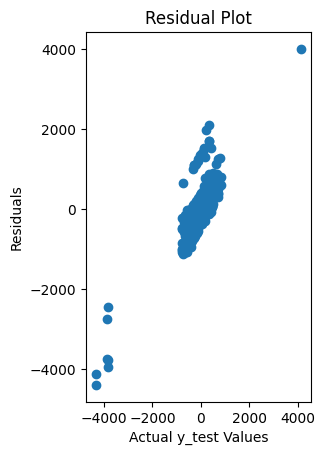

In [51]:
# Select a model from trained_models
selected_model = trained_models[0][1]
freq = trained_models[0][3]

sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
x = sim_data_preproc[predictors]
y = sim_data_preproc['xOffset'] # Will need to adjust this to iterate over x and y xOffset

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

#Fit the model on the training data
selected_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = selected_model.predict(X_test)

# Plot the estimated vs actual predictions
plt.scatter(y_test, y_pred)
plt.xlabel("Actual y_test Values")
plt.ylabel("Predicted y_test Values")
plt.title("Actual vs Predicted Values for y_test")
plt.show()

# Plot the residuals
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals)
plt.xlabel("Actual y_test Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Superseded

In [25]:
insights = []
for freq in frequencies:
    sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
    x = sim_data_preproc[predictors]
    y = sim_data_preproc['xOffset'] # Will need to adjust this to iterate over x and y xOffset

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

    for modelname, Model, params_list in modelclasses:
        for params in params_list:
            model = Model(**params)
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            insights.append((modelname, model, params, freq, score))